In [1]:
#upload kaggle key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bluberry314","key":"6ee4bda8a7e39db01058422193309f67"}'}

In [2]:
#downloading competition data
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'kkbox-music-recommendation-challenge'

 98% 337M/345M [00:04<00:00, 62.2MB/s]
100% 345M/345M [00:05<00:00, 71.6MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')
! unzip kkbox-music-recommendation-challenge.zip -d "/content/drive/My Drive/"

Mounted at /content/drive
Archive:  kkbox-music-recommendation-challenge.zip
  inflating: /content/drive/My Drive/members.csv.7z  
replace /content/drive/My Drive/sample_submission.csv.7z? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/My Drive/song_extra_info.csv.7z? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: /content/drive/My Drive/songs.csv.7z  
replace /content/drive/My Drive/test.csv.7z? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: /content/drive/My Drive/train.csv.7z  


In [4]:
!p7zip -d /content/drive/MyDrive/songs.csv.7z
!p7zip -d /content/drive/MyDrive/train.csv.7z
!p7zip -d /content/drive/MyDrive/members.csv.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 105809525 bytes (101 MiB)

Extracting archive: /content/drive/MyDrive/songs.csv.7z
--
Path = /content/drive/MyDrive/songs.csv.7z
Type = 7z
Physical Size = 105809525
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - songs.csv                  5% - songs.csv                  9% - songs.csv                 12% - songs.csv                 15% - songs.csv                 18% - songs.csv                 

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#loading all the data into a data frame
memberdata = pd.read_csv('/content/members.csv')
songdata = pd.read_csv('/content/songs.csv')
traindata = pd.read_csv('/content/train.csv')

In [6]:
#merging song and member data with the training set
traindata = pd.merge(traindata, songdata, on='song_id', how='left')
traindata = pd.merge(traindata, memberdata, on='msno', how='left')

In [7]:
#visualizing null values by feature including data type
dtypes = pd.DataFrame(traindata.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=traindata.nunique().sort_values(ascending=True)

dtypes["Null Values"]=traindata.isnull().sum()

dtypes["% null Values"]=traindata.isnull().sum()/len(traindata)

dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% null Values
lyricist,object,33888,3178798,0.430882
gender,object,2,2961479,0.401425
composer,object,76064,1675706,0.227140
source_screen_name,object,20,414804,0.056226
genre_ids,object,572,118455,0.016056
source_system_tab,object,8,24849,0.003368
source_type,object,12,21539,0.002920
language,float64,10,150,0.000020
song_length,float64,60266,114,0.000015
artist_name,object,40582,114,0.000015


<Axes: >

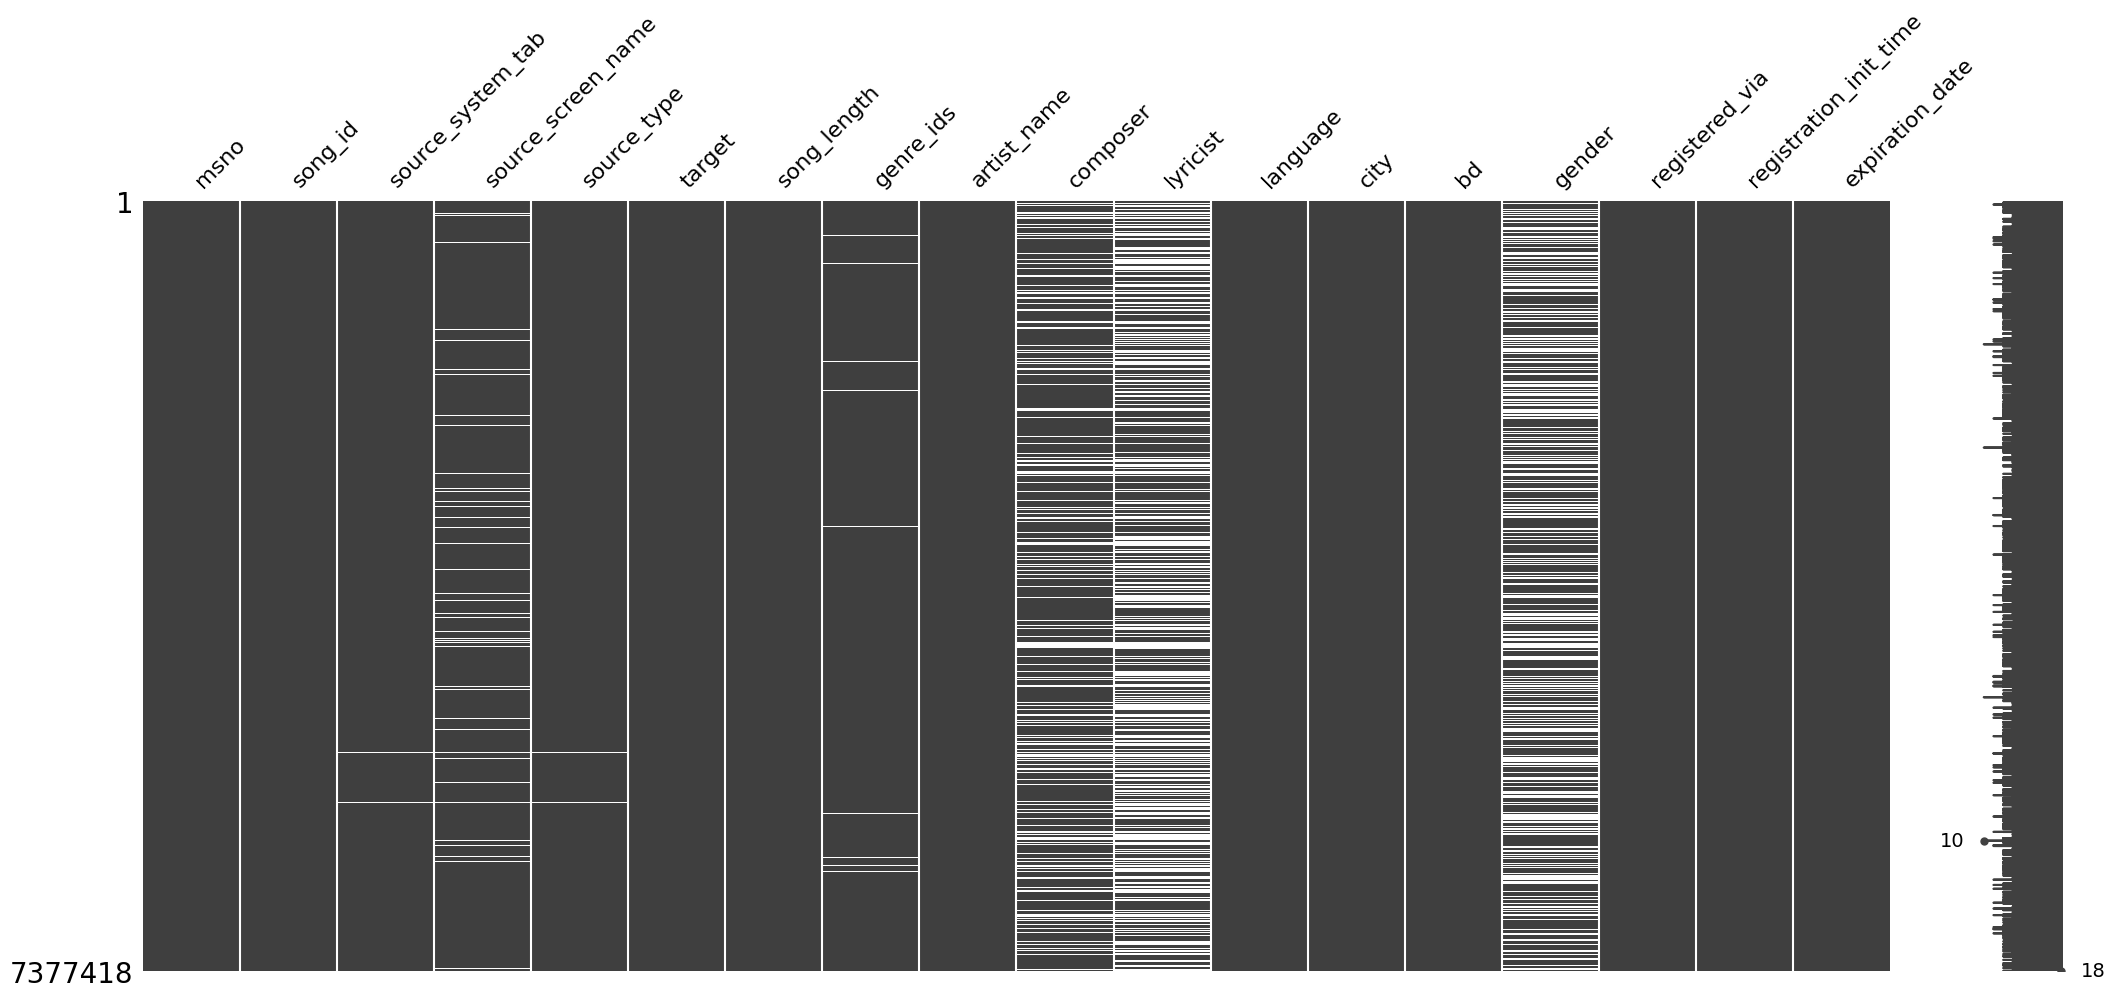

In [8]:
import missingno as msno
msno.matrix(traindata)

In [9]:
# string NA's filled with 'Unknown'
for col in traindata.select_dtypes(include=['object']).columns:
    traindata[col] = traindata[col].fillna(value = "unknown")

# numeric NA's filled with mean
for col in traindata.select_dtypes(exclude=['object']).columns:
    traindata[col] = traindata[col].fillna(value = traindata[col].mean())

<Axes: >

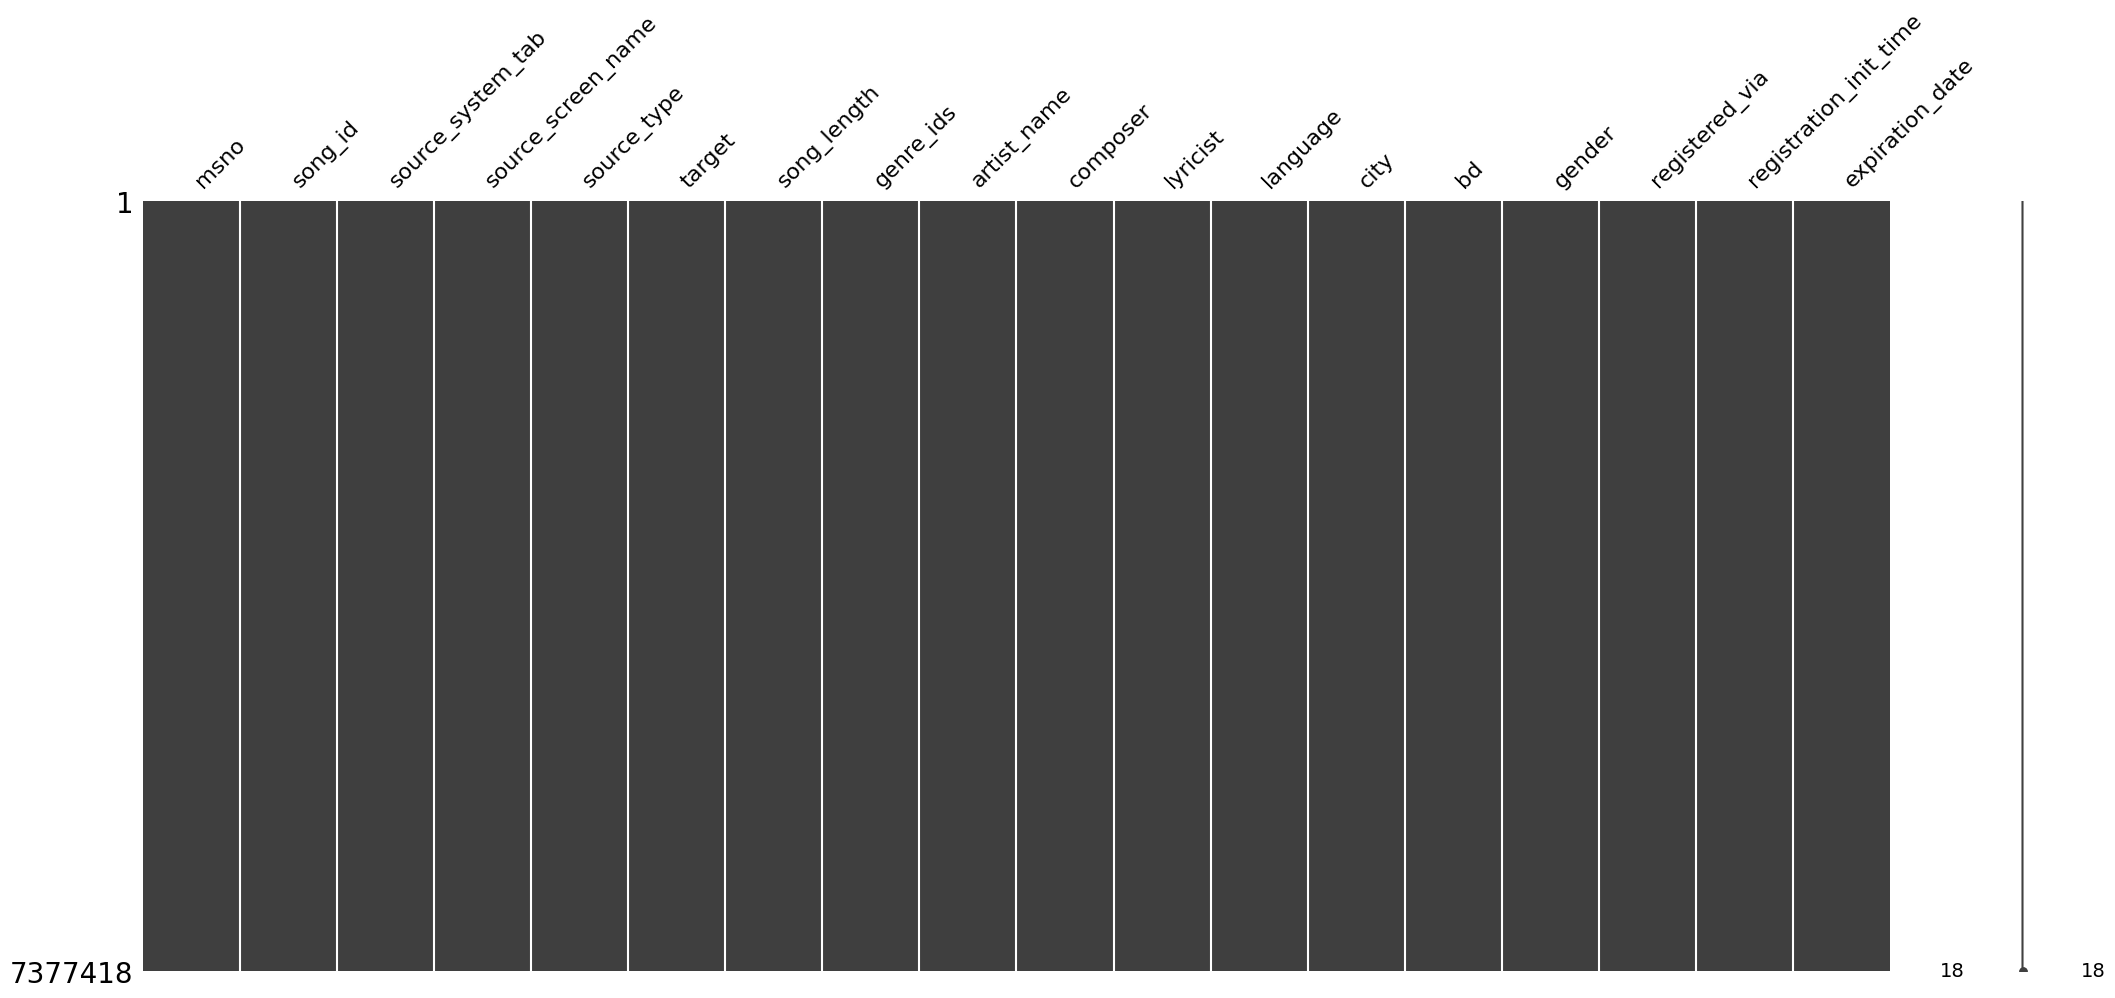

In [10]:
msno.matrix(traindata)

In [11]:
#registration date formatting
traindata.registration_init_time = pd.to_datetime(traindata.registration_init_time, format='%Y%m%d', errors='ignore')
traindata['registration_init_time_year'] = traindata['registration_init_time'].dt.year
traindata['registration_init_time_month'] = traindata['registration_init_time'].dt.month
traindata['registration_init_time_day'] = traindata['registration_init_time'].dt.day

#expiration date formatting
traindata.expiration_date = pd.to_datetime(traindata.expiration_date,  format='%Y%m%d', errors='ignore')
traindata['expiration_date_year'] = traindata['expiration_date'].dt.year
traindata['expiration_date_month'] = traindata['expiration_date'].dt.month
traindata['expiration_date_day'] = traindata['expiration_date'].dt.day

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in traindata.columns :
    traindata[i] = label_encoder.fit_transform(traindata[i])

<ipython-input-13-a558d7a60761>:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='correlation')


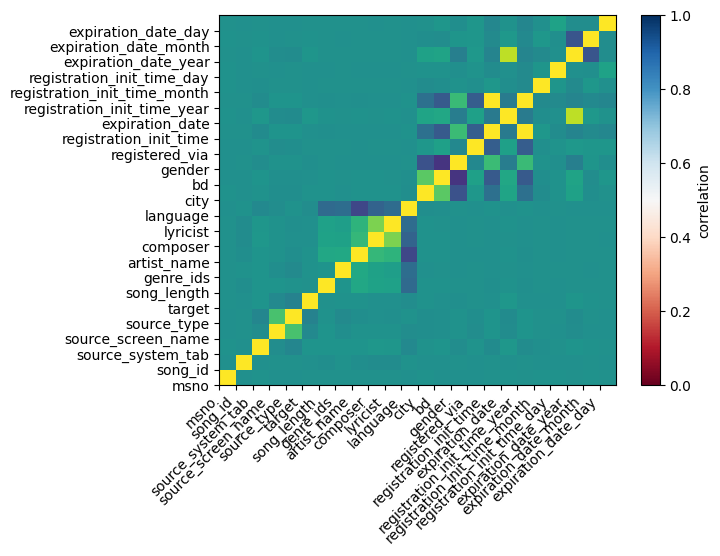

In [13]:
correlation_matrix = traindata.corr()
import matplotlib.pyplot as plt
def plotcor(correlation_matrix):
    fig, ax = plt.subplots()
    ax.pcolor(correlation_matrix, vmin=-1, vmax=1)

    sm = plt.cm.ScalarMappable(cmap='RdBu')
    sm.set_array([])
    plt.colorbar(sm, label='correlation')

    ax.set_xticks(np.arange(len(correlation_matrix.columns)))
    ax.set_yticks(np.arange(len(correlation_matrix.columns)))
    ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(correlation_matrix.columns)

    plt.show()

result = plotcor(correlation_matrix.copy())

In [15]:
traindata.shape

(7377418, 24)

In [16]:
unknown = traindata['gender'].value_counts().get(0,0)
female = traindata['gender'].value_counts().get(1,0)
male = traindata['gender'].value_counts().get(2,0)

total = len(traindata['gender'])

u = (unknown/total) * 100
f =  (female/total) * 100
m = (male/total) * 100

print("Pecentage of Unknown Gendered Users:", u)
print("Percentage of Female Users:", f)
print("Percentage of Male Users:", m)

Pecentage of Unknown Gendered Users: 28.71351467410414
Percentage of Female Users: 31.14399916068196
Percentage of Male Users: 40.142486165213896


In [17]:
print('Average Song Length (Minutes):',(traindata['song_length'].mean())/6000)

Average Song Length (Minutes): 4.61225555815508


In [18]:
traindata = traindata.sample(frac = 0.25) #too big otherwise
X = traindata.drop('target', axis = 1)
y = traindata['target']

-------- Decision Tree --------


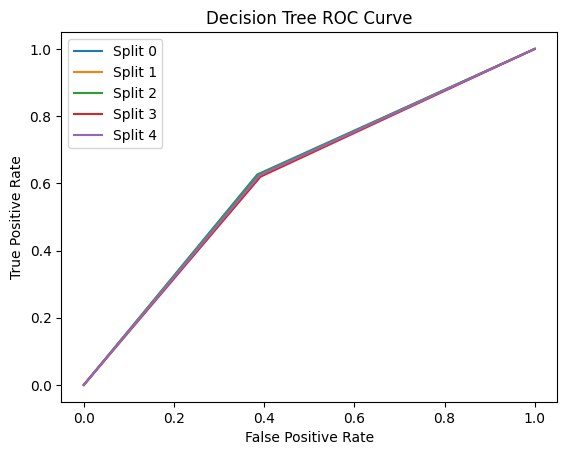

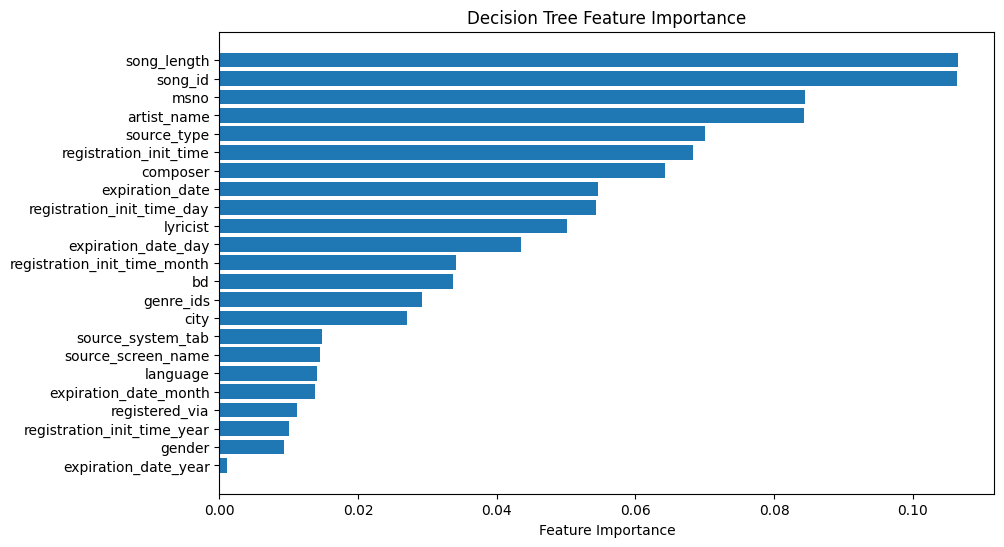

Summary of Performance Metrics:
Split	Accuracy	Precision	Recall	F1 Score
0	0.6208		0.6214		0.6262	0.6238
1	0.6189		0.6210		0.6244	0.6227
2	0.6192		0.6210		0.6248	0.6229
3	0.6140		0.6153		0.6196	0.6175
4	0.6172		0.6185		0.6239	0.6212


-------- LightGBM --------
[LightGBM] [Info] Number of positive: 742743, number of negative: 732740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2433
[LightGBM] [Info] Number of data points in the train set: 1475483, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503390 -> initscore=0.013559
[LightGBM] [Info] Start training from score 0.013559
[LightGBM] [Info] Number of positive: 742152, number of negative: 733331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187997 seconds.
Y

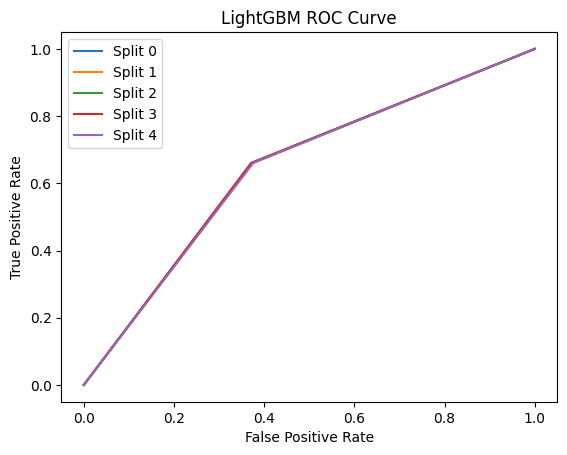

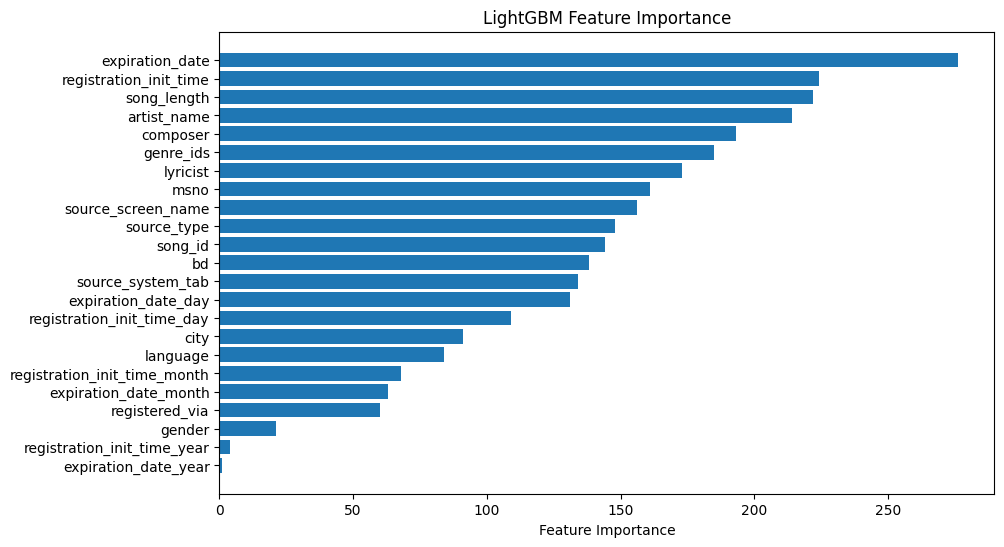

Summary of Performance Metrics:
Split	Accuracy	Precision	Recall	F1 Score
0	0.6444		0.6414		0.6612	0.6512
1	0.6436		0.6427		0.6581	0.6503
2	0.6438		0.6418		0.6612	0.6514
3	0.6448		0.6430		0.6604	0.6516
4	0.6426		0.6403		0.6611	0.6505


-------- Random Forest --------


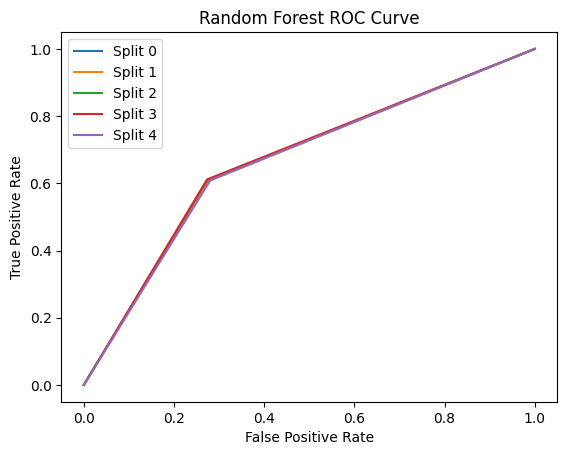

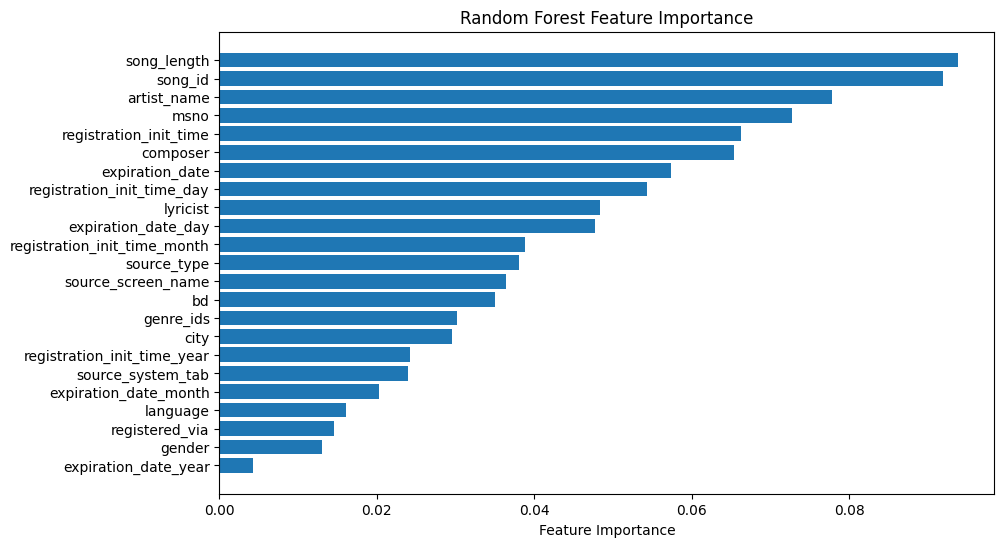

Summary of Performance Metrics:
Split	Accuracy	Precision	Recall	F1 Score
0	0.6650		0.6891		0.6064	0.6451
1	0.6646		0.6897		0.6074	0.6459
2	0.6680		0.6933		0.6103	0.6492
3	0.6687		0.6934		0.6117	0.6500
4	0.6642		0.6873		0.6102	0.6465




In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, auc, f1_score, make_scorer, precision_score, recall_score

#performance metrics for each model
models = [DecisionTreeClassifier(), LGBMClassifier(), RandomForestClassifier(n_estimators=10)]
model_names = ['Decision Tree', 'LightGBM', 'Random Forest']

#splits
num_splits = 5

metrics = {
    'Accuracy': accuracy_score,
    'Precision': make_scorer(precision_score, pos_label=1),  #binary classification
    'Recall': make_scorer(recall_score, pos_label=1),  #binary classification
    'F1 Score': make_scorer(f1_score, pos_label=1),  #binary classification
}

for model, model_name in zip(models, model_names):
    print(f"-------- {model_name} --------")
    #performance metrics list
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(num_splits):
        #test train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        #classifer
        model.fit(X_train, y_train)

        #predictions
        y_pred = model.predict(X_test)

        #evaluation
        accuracy = accuracy_score(y_test, y_pred)

        #precision and recall and F1 score
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        f1 = 2 * (precision * recall) / (precision + recall)

        #save scores
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        #ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f'Split {i}')


    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    #feature importance
    if model_name in ['Decision Tree', 'LightGBM', 'Random Forest']:
        feature_importance = model.feature_importances_
        feature_names = X.columns if hasattr(X, 'columns') else range(len(feature_importance))

        sorted_idx = np.argsort(feature_importance)
        features_sorted = [feature_names[i] for i in sorted_idx]
        importance_sorted = [feature_importance[i] for i in sorted_idx]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importance)), importance_sorted, align='center')
        plt.yticks(range(len(feature_importance)), features_sorted)
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} Feature Importance')
        plt.show()

    #summary tables
    print("Summary of Performance Metrics:")
    print("Split\tAccuracy\tPrecision\tRecall\tF1 Score")
    for i in range(num_splits):
        print(f"{i}\t{accuracies[i]:.4f}\t\t{precisions[i][1]:.4f}\t\t{recalls[i][1]:.4f}\t{f1_scores[i][1]:.4f}")
    print("\n")

